In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#https://www.kaggle.com/spscientist/students-performance-in-exams
dataset = pd.read_csv("data/StudentsPerformance.csv")

In [4]:
dataset.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [5]:
dataset.isnull().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [6]:
dataset.dtypes

gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

Text(0.5, 0.98, 'Распределение баллов')

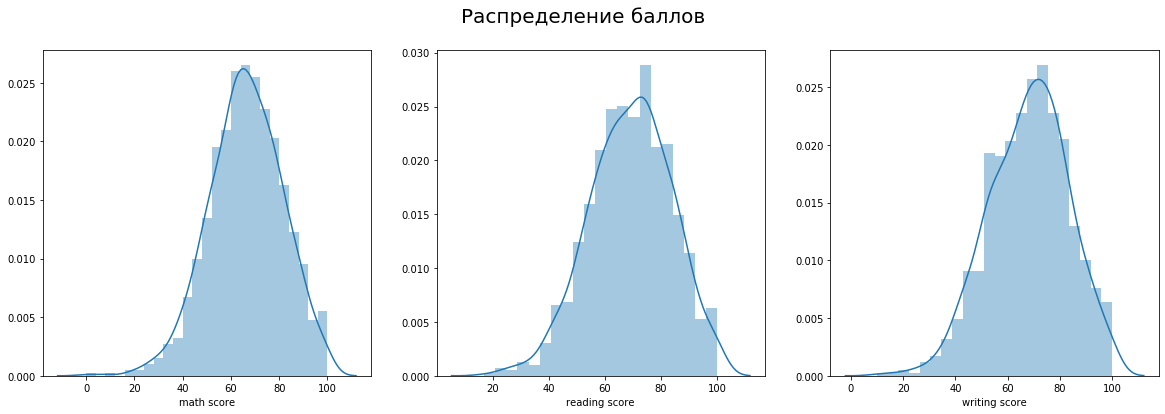

In [7]:
f, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.distplot(dataset['math score'], ax=axes[0])
sns.distplot(dataset['reading score'], ax=axes[1])
sns.distplot(dataset['writing score'], ax=axes[2])
f.suptitle("Распределение баллов",size=20)

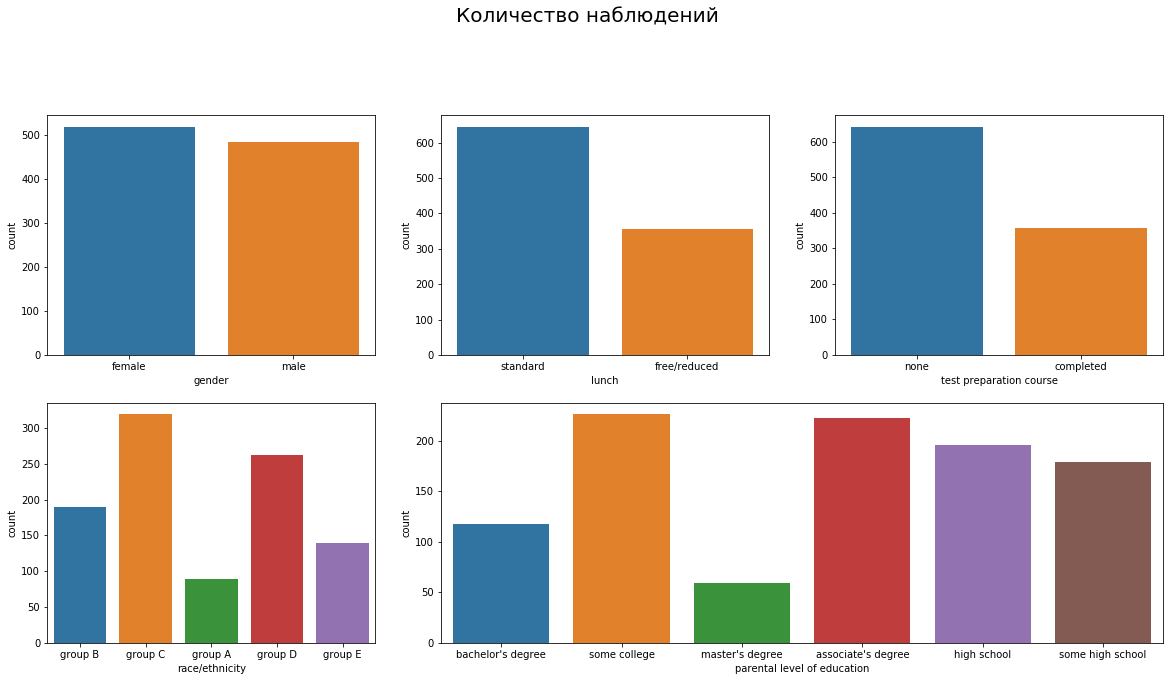

In [8]:
f = plt.figure(figsize=(20,15))
f.suptitle("Количество наблюдений", size=20)
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)
ax_0 = f.add_subplot(grid[0, 0])
ax_1 = f.add_subplot(grid[0, 1])
ax_2 = f.add_subplot(grid[0, 2])
ax_3 = f.add_subplot(grid[1, 0])
ax_4 = f.add_subplot(grid[1, 1:])
sns.countplot(dataset['gender'], ax=ax_0)
sns.countplot(dataset['lunch'], ax=ax_1)
sns.countplot(dataset['test preparation course'], ax=ax_2)
sns.countplot(dataset['race/ethnicity'], ax=ax_3)
sns.countplot(dataset['parental level of education'], ax=ax_4)

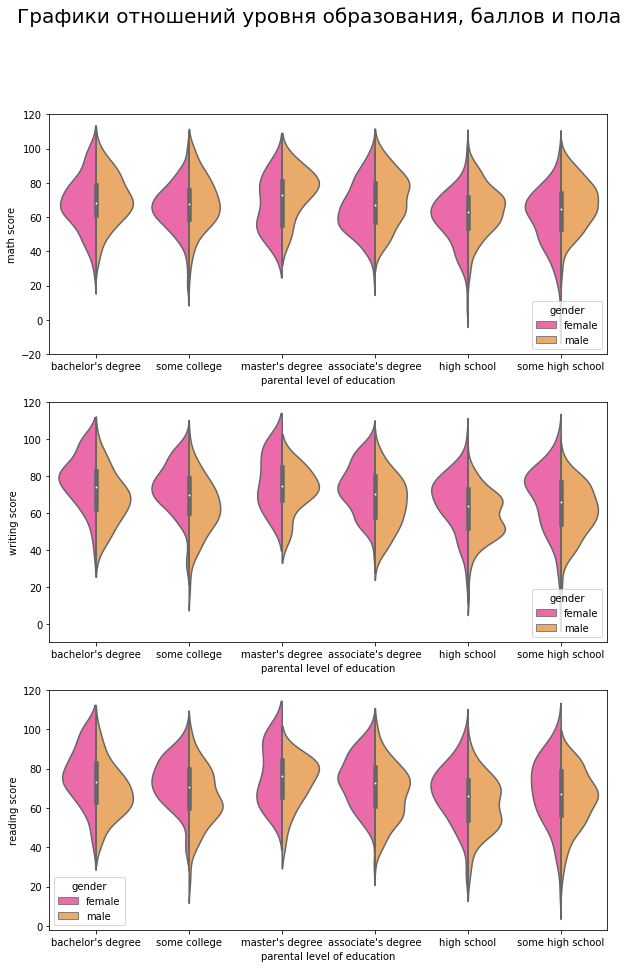

In [9]:
f, axes = plt.subplots(3, 1, figsize=(10, 15))
f.suptitle("Графики отношений уровня образования, баллов и пола", size=20)
sns.catplot(x="parental level of education", y='math score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[0], palette='spring');
plt.close(plt.gcf())
sns.catplot(x="parental level of education", y='writing score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[1], palette='spring');
plt.close(plt.gcf())
sns.catplot(x="parental level of education", y='reading score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[2], palette='spring');
plt.close(plt.gcf())

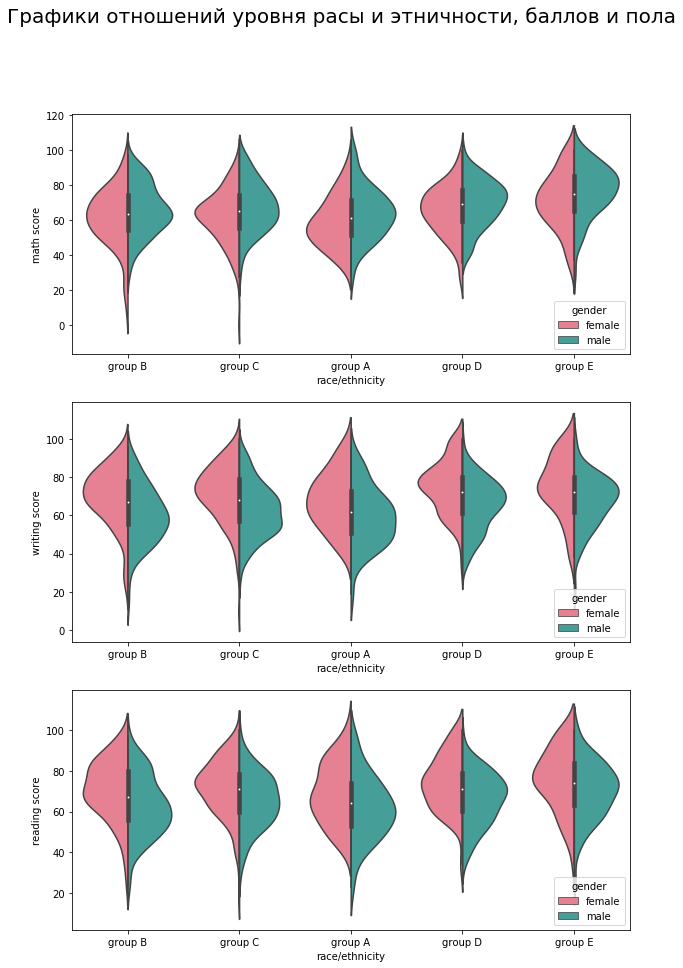

In [10]:
f, axes = plt.subplots(3, 1, figsize=(10, 15))
f.suptitle("Графики отношений уровня расы и этничности, баллов и пола", size=20)
sns.catplot(x="race/ethnicity", y='math score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[0], palette='husl');
plt.close(plt.gcf())
sns.catplot(x="race/ethnicity", y='writing score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[1], palette='husl');
plt.close(plt.gcf())
sns.catplot(x="race/ethnicity", y='reading score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[2], palette='husl');
plt.close(plt.gcf())

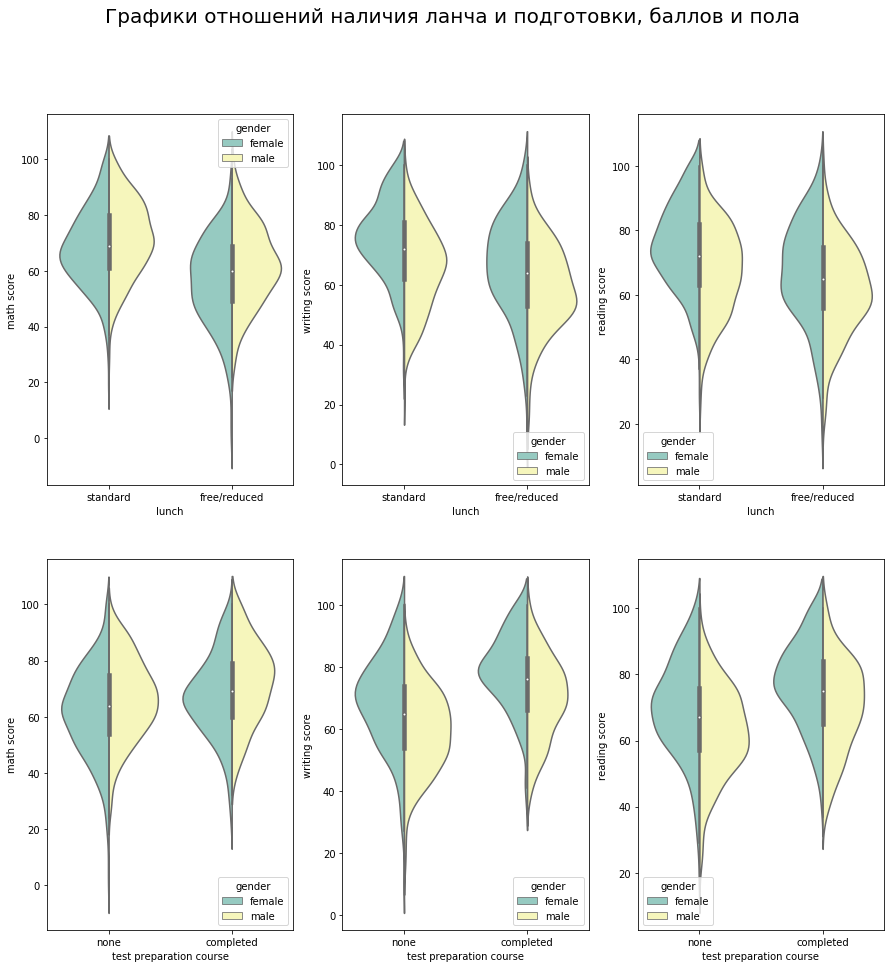

In [11]:
f, axes = plt.subplots(2, 3, figsize=(15, 15))
f.suptitle("Графики отношений наличия ланча и подготовки, баллов и пола", size=20)
sns.catplot(x="lunch", y='math score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[0,0], palette='Set3');
plt.close(plt.gcf())
sns.catplot(x="lunch", y='writing score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[0,1], palette='Set3');
plt.close(plt.gcf())
sns.catplot(x="lunch", y='reading score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[0,2], palette='Set3');
plt.close(plt.gcf())
sns.catplot(x="test preparation course", y='math score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[1,0], palette='Set3');
plt.close(plt.gcf())
sns.catplot(x="test preparation course", y='writing score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[1,1], palette='Set3');
plt.close(plt.gcf())
sns.catplot(x="test preparation course", y='reading score', hue="gender", kind="violin", split=True, data=dataset, ax=axes[1,2], palette='Set3');
plt.close(plt.gcf())

In [12]:
#Series.cat.codes: return Series of codes as well as the index.
def change_with_cat_codes(df, list_of_columns):
    for column in list_of_columns:
        df[column] = df[column].astype('category').cat.codes
    return df

Text(0.5, 1, 'Корреляция между признаками')

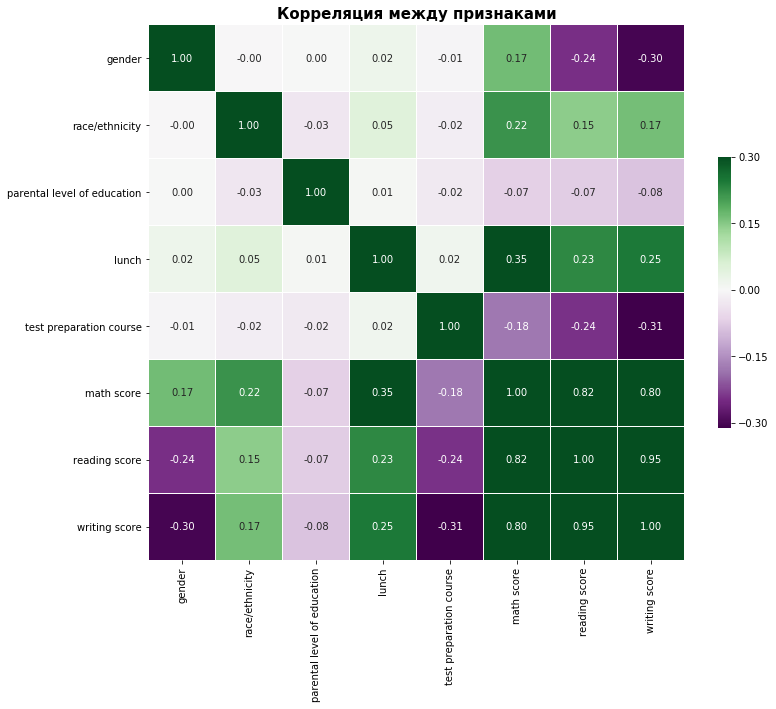

In [13]:
'''
Для более стабильной регрессии следуюет убирать признаки, которые имеют
высокую корреляцию с зависимой переменной у, так как при высокой корреляции
увеличивается дисперсия вектора весов.
https://towardsdatascience.com/why-exclude-highly-correlated-features-when-building-regression-model-34d77a90ea8e
'''
plt.figure(figsize=(12,10))
#чтобы построить матрицу корреляции, необходимо изменить категориальные данные
corr = change_with_cat_codes(dataset, ['gender', 'lunch', 'test preparation course', 'race/ethnicity', 'parental level of education']).corr(method='pearson') 
sns.heatmap(corr, annot=True, fmt='.2f', cmap='PRGn', vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}).set(ylim=(8, 0))
plt.title("Корреляция между признаками", size=15, weight='bold')

In [14]:
'''
Мультиколлинеарность — наличие линейной зависимости между объясняющими переменными (факторами) регрессионной модели.
Один из способов нахождения мультиколлинеарности - нахождение собственных значений (eigenvalues) корреляционной матрицы.
Малые и нулевые значения собственных значений свидетельствует о наличии мультиколлинеарности.
'''
eigenvalues, eigenvectors = np.linalg.eig(corr.iloc[:-3,:-3])
eigenvalues

array([0.92353886, 1.05643533, 0.98821921, 1.02372122, 1.00808538])

In [15]:
dataset.loc[dataset['math score'] >= 60, "math_>=60"] = 1
dataset.loc[dataset['reading score'] >= 60, "reading_>=60"] = 1
dataset.loc[dataset['writing score'] >= 60, "writing_>=60"] = 1
dataset = dataset.fillna(0)

In [16]:
dataset.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,math_>=60,reading_>=60,writing_>=60
0,0,1,1,1,1,72,72,74,1.0,1.0,1.0
1,0,2,4,1,0,69,90,88,1.0,1.0,1.0
2,0,1,3,1,1,90,95,93,1.0,1.0,1.0
3,1,0,0,0,1,47,57,44,0.0,0.0,0.0
4,1,2,4,1,1,76,78,75,1.0,1.0,1.0


In [17]:
x = dataset.iloc[:,:-6]
y1 = dataset.iloc[:,-3]
y2 = dataset.iloc[:,-2]
y3 = dataset.iloc[:,-1]
y = (dataset['math score'] + dataset['reading score'] + dataset['writing score']) / 3

In [18]:
scaler = MinMaxScaler().fit(x)
x_scaled = scaler.transform(x)

In [19]:
#регрессия
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
#классификация
X1_train, X1_test, y1_train, y1_test = train_test_split(x, y1, random_state=5)
X2_train, X2_test, y2_train, y2_test = train_test_split(x, y2, random_state=5)
X3_train, X3_test, y3_train, y3_test = train_test_split(x, y3, random_state=5)

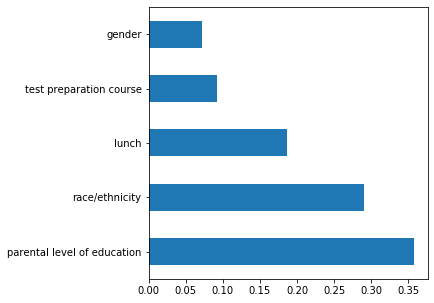

In [22]:
'''
С помощью ExtraTreesClassifier можно построить график значимости признаков и проанализировать его.
LabelEncoder необходим для преобразавания чисел в y в целые числа, так как используется классификатор. 
'''
label_enc = LabelEncoder()
feature_model = ExtraTreesClassifier(n_estimators=50)
feature_model.fit(X1_train, y1_train)
feature_importences = pd.Series(feature_model.feature_importances_, index=X1_train.columns)
plt.figure(figsize=(5,5))
feature_importences.nlargest(X1_train.shape[1]).plot(kind='barh')

In [23]:
#Нахождение оптимальных параметров для каждого вида регресии.
param_grid = {'n_estimators': [2, 3, 4, 5, 10, 50, 100]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid).fit(X1_train, y1_train)
print("Лучшие параметры: {}".format(grid_search.best_params_))
print("Лучший результат: {:.3f}".format(grid_search.best_score_))
print("Правильность на тестовом наборе: {:.3f}".format(grid_search.score(X1_test, y1_test)))

Лучшие параметры: {'n_estimators': 3}
Лучший результат: 0.653
Правильность на тестовом наборе: 0.656


In [24]:
param_grid = {'max_depth': [2, 3, 5, 7, 10]}
grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid).fit(X1_train, y1_train)
print("Лучшие параметры: {}".format(grid_search.best_params_))
print("Лучший результат: {}".format(grid_search.best_score_))
print("Правильность на тестовом наборе: {:.3f}".format(grid_search.score(X1_test, y1_test)))

Лучшие параметры: {'max_depth': 2}
Лучший результат: 0.7066666666666667
Правильность на тестовом наборе: 0.688


In [25]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(SVC(), param_grid).fit(X1_train, y1_train)
print("Лучшие параметры: {}".format(grid_search.best_params_))
print("Лучший результат: {}".format(grid_search.best_score_))
print("Правильность на тестовом наборе: {:.3f}".format(grid_search.score(X1_test, y1_test)))

Лучшие параметры: {'C': 100, 'gamma': 0.01}
Лучший результат: 0.692
Правильность на тестовом наборе: 0.680


In [26]:
def show_results(estimator, x, y1, y2, y3):
    estimatorScores = cross_val_score(estimator, x, y1)
    print('\ny1')
    print("Результат перекрестной проверки: {}".format(estimatorScores))
    print("Средняя правильность перекрестной проверки: {:.3f}".format(estimatorScores.mean()))

    print('\ny2')
    estimatorScores = cross_val_score(estimator, x, y2)
    print("Результат перекрестной проверки: {}".format(estimatorScores))
    print("Средняя правильность перекрестной проверки: {:.3f}".format(estimatorScores.mean()))

    print('\ny3')
    estimatorScores = cross_val_score(estimator, x, y3)
    print("Результат перекрестной проверки: {}".format(estimatorScores))
    print("Средняя правильность перекрестной проверки: {:.3f}".format(estimatorScores.mean()))

In [27]:
print('LogisticRegression')
show_results(LogisticRegression(penalty="l2"), x, y1, y2, y3)

print('\nLogisticRegression scaled')
show_results(LogisticRegression(penalty="l2"), x_scaled, y1, y2, y3)

LogisticRegression

y1
Результат перекрестной проверки: [0.72155689 0.72754491 0.69578313]
Средняя правильность перекрестной проверки: 0.715

y2
Результат перекрестной проверки: [0.75449102 0.75149701 0.73795181]
Средняя правильность перекрестной проверки: 0.748

y3
Результат перекрестной проверки: [0.75149701 0.76347305 0.73192771]
Средняя правильность перекрестной проверки: 0.749

LogisticRegression scaled

y1
Результат перекрестной проверки: [0.71257485 0.72754491 0.70180723]
Средняя правильность перекрестной проверки: 0.714

y2
Результат перекрестной проверки: [0.76047904 0.75149701 0.73795181]
Средняя правильность перекрестной проверки: 0.750

y3
Результат перекрестной проверки: [0.74850299 0.76646707 0.73493976]
Средняя правильность перекрестной проверки: 0.750


In [28]:
print('GradientBoostingClassifier')
show_results(GradientBoostingClassifier(max_depth=2), x, y1, y2, y3)

GradientBoostingClassifier

y1
Результат перекрестной проверки: [0.69461078 0.68862275 0.70180723]
Средняя правильность перекрестной проверки: 0.695

y2
Результат перекрестной проверки: [0.76946108 0.73652695 0.73493976]
Средняя правильность перекрестной проверки: 0.747

y3
Результат перекрестной проверки: [0.75748503 0.74251497 0.73795181]
Средняя правильность перекрестной проверки: 0.746


In [29]:
print('SVC')
show_results(SVC(C= 100, gamma= 0.01), x, y1, y2, y3)

SVC

y1
Результат перекрестной проверки: [0.70359281 0.70658683 0.6686747 ]
Средняя правильность перекрестной проверки: 0.693

y2
Результат перекрестной проверки: [0.74550898 0.74550898 0.74698795]
Средняя правильность перекрестной проверки: 0.746

y3
Результат перекрестной проверки: [0.73652695 0.73353293 0.74096386]
Средняя правильность перекрестной проверки: 0.737
